In [1]:
# Setup show/hide source code box
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="show/hide source code"></form>''')

In [2]:
# Import libraries and setup matplotlib defaults
from matplotlib import pyplot as pl
import pandas as pd
import numpy as np
pl.style.use('fivethirtyeight')
pl.rcParams.update({
    'lines.linewidth': 2,
    'font.size': 20,
    'figure.figsize': [12, 8],
    'figure.subplot.left': 0.125,
    'figure.subplot.right': 0.95,
    'figure.subplot.bottom': 0.15})

In [3]:
# Load data
scotus_data = pd.read_csv('SCOTUS.csv',
                          parse_dates=['DOB', 'debut', 'retire', 'DOD'],
                          na_values='99/99/9999')

# Calculate derived values
scotus_data.fillna(np.datetime64('2021-01-02'), inplace=True)
scotus_data['died in office']=(scotus_data['retire']==scotus_data['DOD']).astype(int)
scotus_data['days since last'] = scotus_data['debut'].diff()
scotus_data['years since last'] = scotus_data['days since last'].apply(lambda x: x.days)/365.24
scotus_data['age at start'] = (scotus_data['debut']-scotus_data['DOB']).apply(lambda x: x.days)/365.24
scotus_data['age at end'] = (scotus_data['retire']-scotus_data['DOB']).apply(lambda x: x.days)/365.24
scotus_data['years of service'] = (scotus_data['retire']-scotus_data['debut']).apply(lambda x: x.days)/365.24
scotus_data['name'] = scotus_data['Fname'] + ' ' + scotus_data['LName']
scotus_data.drop(['Fname', 'LName'], 1, inplace=True)

# Calculate average age
years = np.array([np.datetime64(str(yr)+'-01-01') for yr in np.arange(1791,2022)])
ages = []
for year in years:
    ages.append((year - scotus_data.loc[(scotus_data.debut<year) & (scotus_data.retire>year), 'DOB']).mean())    

average_age = pd.DataFrame(ages, index=years, columns=['days'])
average_age.index.name='date'
average_age['years'] = average_age['days'].apply(lambda x: x.days)/365.24

ys_data = scotus_data.sort_values('retire')[:-9].rename(columns={'retire':'retirement date'})

## Average age of court
The average age of the justices currently serving on January 1 of each year. The 3 recent appointments have reduced the average age by over 5 years, but the court is still somewhat older than it was in the mid 1990s, when the average age was just over 60.

In [4]:
average_age[-5:][['years']].round(1)

,years
date,
2017-01-01,69.9
2018-01-01,68.6
2019-01-01,66.4
2020-01-01,67.4
2021-01-01,64.1


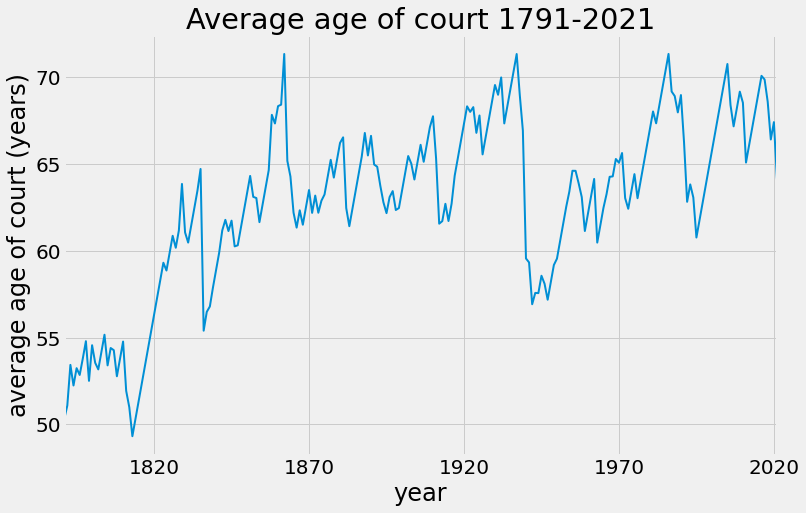

In [5]:
ax = average_age['years'].plot()
ax.set_xlabel('year')
ax.set_ylabel('average age of court (years)')
val = ax.set_title('Average age of court 1791-2021')

## Distance between appointments
Only 3 times have more than 6 years elapsed between appointments to the court. The John Roberts appointment in 2005 was over 11 years since the previous appointment, the longest such interval since 1823.

In [6]:
print('average time between appointments: {0:.1f}'.format(
    scotus_data['years since last'].mean()))
scotus_data.set_index('debut').sort_values('years since last', ascending=False).round(1)[
    ['years since last', 'name']][:3]

average time between appointments: 2.0


,years since last,name
debut,,
1823-09-01,11.6,Smith Thompson
2005-09-29,11.2,John Roberts
2017-03-10,6.6,Neil Gorsuch


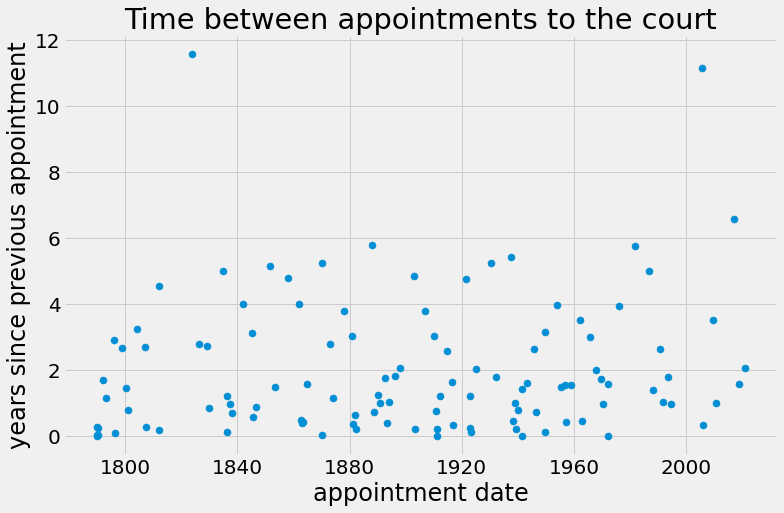

In [7]:
ax = scotus_data.plot.scatter('debut','years since last', s=50)
ax.set_xlabel('appointment date')
ax.set_ylabel('years since previous appointment')
val = ax.set_title('Time between appointments to the court')

## Age at appointment over time
Since about 1820, new nominees have tended to be between 45 and 65. In the last 25 years, that window seems to have narrowed somewhat, with nobody under 60 being nominated.

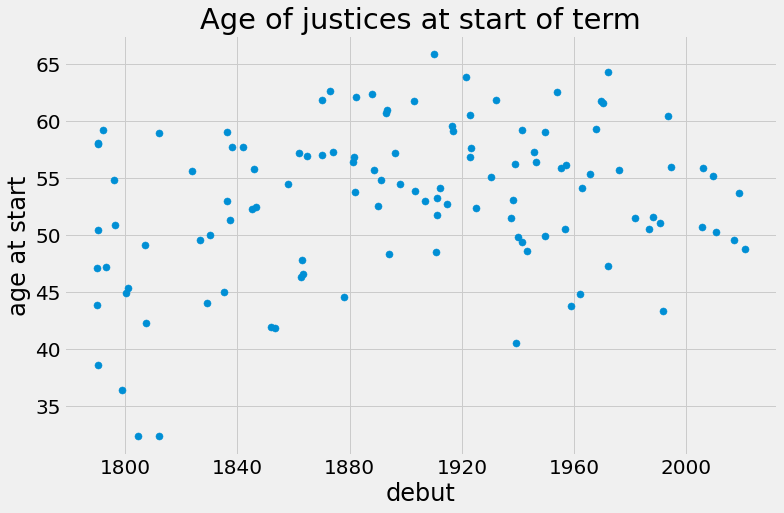

In [8]:
ax = scotus_data.plot.scatter('debut','age at start', s=50)
val = ax.set_title('Age of justices at start of term')

## Years of service at retirement
Those currently serving on the court have been exluded from this analysis. Average term over the entire history is just under 17 years, but that number has increased significantly in the last 50 years with a notable disapperance of short terms of service. It is now far less likely in the past for a justice to die in office, with the only cases since 1960 being Rehnquist, Scalia, and Ginsburg.

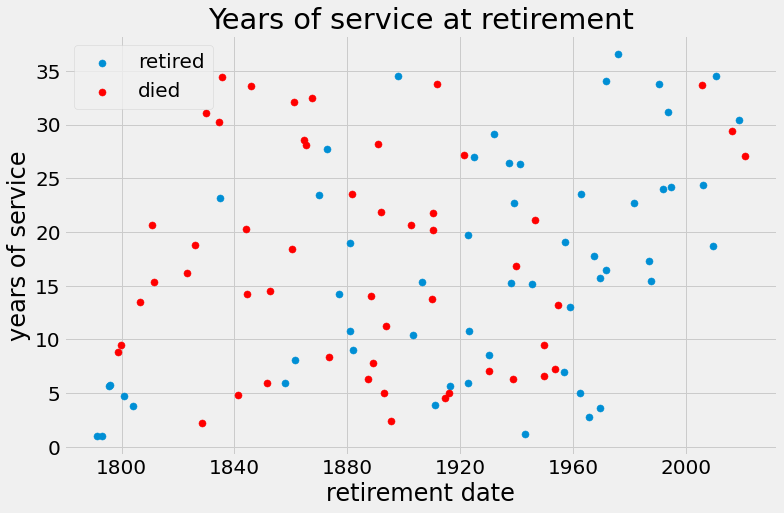

In [9]:
from matplotlib import colors
ax = ys_data[ys_data['died in office']==0].plot.scatter('retirement date', 'years of service', s=50, label='retired')
ys_data[ys_data['died in office']==1].plot.scatter('retirement date', 'years of service', s=50, c='r', label='died', ax=ax)
val = ax.set_title('Years of service at retirement')

## Stats by eras
1970 appears to be something of a turning point. Since then, no justice has retired or died after serving fewer than 15 years. Using 1970 as a reference point, all justices have been grouped into 50-year eras based on their retirement date. In the period since 1970, relative to previous eras, justices are appointed younger, retire older, and are far less likely to die in office.

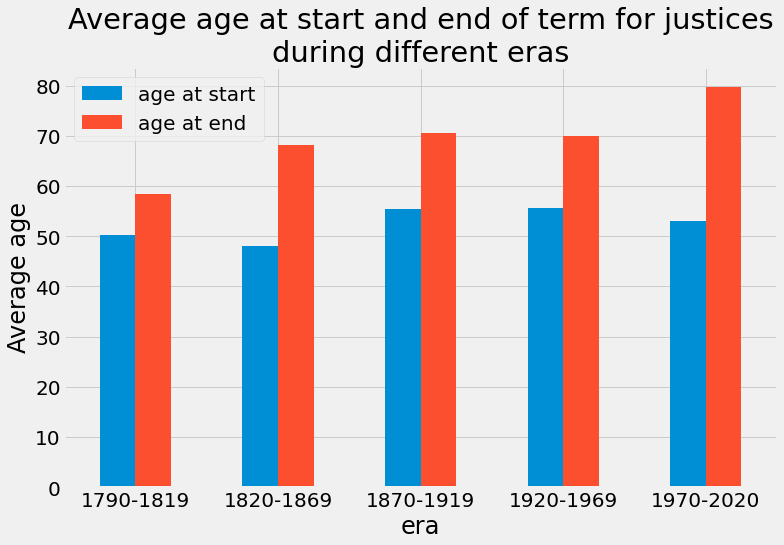

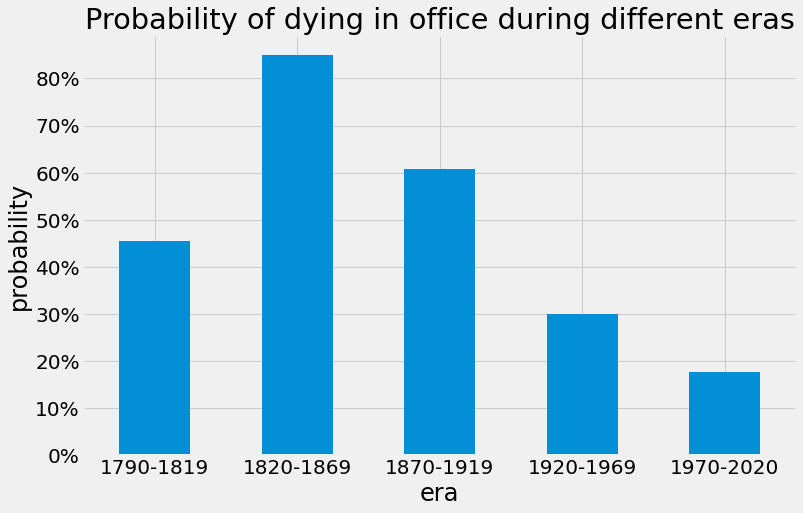

In [10]:
ps = ys_data['retirement date'].apply(lambda x: int((x.year-20)/50)*50+20)
era_dict = {1770: '1790-1819', 1820: '1820-1869', 1870: '1870-1919',
            1920: '1920-1969', 1970:'1970-2020', 2020:'1970-2020'}
ys_data['era'] = ps.apply(lambda x: era_dict[x])

period_analysis = ys_data.groupby('era').mean()[['years of service', 'age at start', 'age at end', 'died in office']]
period_analysis['number'] = ys_data.groupby('era').size()
ax = period_analysis[['age at start', 'age at end']].plot.bar(rot=0)
ax.set_ylabel('Average age')
ax.set_title('Average age at start and end of term for justices\nduring different eras')

import matplotlib.ticker as mtick
ax = (period_analysis[['died in office']]*100).plot.bar(legend=False, rot=0)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_title('Probability of dying in office during different eras')
val = ax.set_ylabel('probability')

## Appointments per presidential term
Calculate the beginning date of the presidential term for each appointment and use that to compute the number of appointments in each presidential term since 1789. Divide the terms into eras of 12 presidential terms and compute the average number of appointments in each era.

In [11]:
scotus_data['pres_term'] = scotus_data['debut'].apply(lambda x: int((x.year-1)/4)*4+1)
appoints_per_term = pd.DataFrame(index=range(1789, 2021, 4))
appoints_per_term['appointments'] = 0
appoints_per_term['ttba'] = 0

for idx, vals in scotus_data.iterrows():
    appoints_per_term.loc[vals['pres_term'], 'appointments'] += 1
    appoints_per_term.loc[vals['pres_term'], 'ttba'] += vals['years since last']
appoints_per_term['mean time between appointments'] = appoints_per_term['ttba']/\
    appoints_per_term['appointments']

era_dict_term = {1781: '1793-1828', 1829: '1829-1876', 1877: '1877-1921',
                 1925: '1925-1972', 1973: '1973-2020'}
appoints_per_term['era'] = appoints_per_term.index.map(
    lambda x: era_dict_term[int((x-5)/48)*48+5])
# Exclude 1789 term
appoints_per_term = appoints_per_term[1:]
appoints_per_term.groupby('era')[
    ['appointments', 'mean time between appointments']].mean().round(2)

,appointments,mean time between appointments
era,,
1793-1828,1.44,3.39
1829-1876,1.92,2.52
1877-1921,2.42,2.10
1925-1972,2.33,1.85
1973-2020,1.25,3.44


## CDF of length of service
This shows the computed cumulative density function (CDF) of the length of service for all retired justices. It shows a more or less uniform distribution from zero about 34 years (with one outlier longer than 34). Mean length of service is 15.4 years and the median is 16.6. This distribution is interesting in the context of discussions about the possibility of term limits for justices on the Supreme Court. A common proposal is for terms that expire at 2-year intervals, which would mean 18-year terms for a 9-member court. An 18-year term would be longer than 56% of all past terms on the court. Under a similar scheme for an 11-member court, that would be a 22-year term, longer than 68% of all terms.

In [12]:
ys = scotus_data['years of service']
pd.DataFrame((('mean length of service', ys.mean()),
              ('median length of service', ys.median()),
              ('% terms less than 18 years', (ys<18).astype(int).mean()*100),
              ('% terms less than 22 years', (ys<22).astype(int).mean()*100)),
                columns=('CDF stats', '')).round(1).set_index('CDF stats')

,
CDF stats,
mean length of service,16.6
median length of service,15.4
% terms less than 18 years,56.5
% terms less than 22 years,67.8


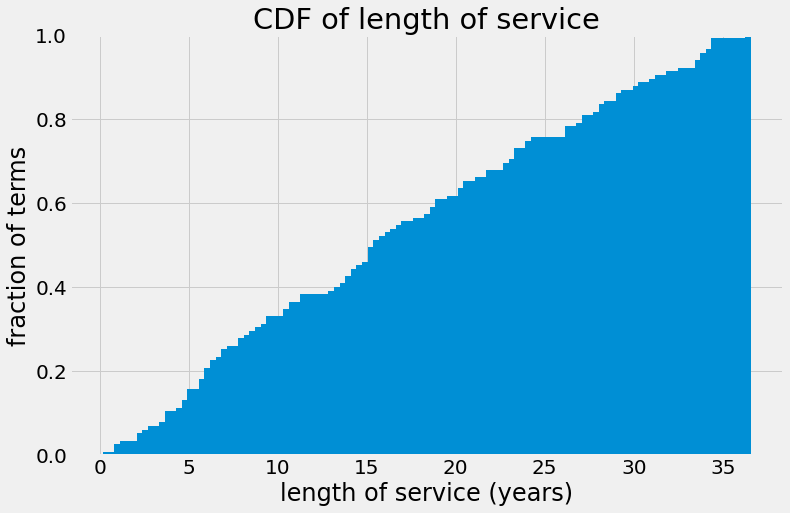

In [13]:
ax = scotus_data['years of service'].hist(cumulative=True, density=1, bins=len(scotus_data))
ax.set_title('CDF of length of service')
ax.set_xlabel('length of service (years)')
ax.set_ylabel('fraction of terms')
val = ax.set_ylim(ymax=1)

## Conclusion
By all measures, there was a clear shift around 1970. Since then, justices have been slightly younger when appointed, have retired at an age 10 years above the previous average (nearly 80 rather than 70), and have been far less likely to die in office. These factors have combined to nearly double the average time between vacancies, thus raising the stakes associated with every vacancy.